# Introduction to NLP Fundamental in Tensorflow

NLP has the goal of deriving informatoin out pf natural language (could be seqeuences text or speech).

Another common term for NLP problem is sequence to sequence problems (seq2seq)


## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b99417a9-20cf-a02a-531f-d6deee409fc6)


## Get helper funcations

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-06 16:43:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-06 16:43:50 (78.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
the dataset we're going to be using ia Kaggle's introduction to NLP dataset (text sample of Tweets labelled as diaster or not diaster).

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-03-06 16:44:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 108.177.12.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-06 16:44:01 (107 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset
To visualize our text samples, we first have to read them in, one way to do so would be to use python (realpython.com)


But i prefer to get visual stright away.


so another way to do is to use pandas...


In [4]:
# read the csv file
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
train_df_shuffled = train_df.sample(frac=1  , random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# what does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# how many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df) ,len(test_df)

(7613, 3263)

In [10]:
# let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row 
  print(f"Target: {target} ", "(real diaster)" if target > 0 else "(not real diaster)")
  print(f"Text:\n{text}\n")
  print("---")


Target: 0  (not real diaster)
Text:
What the fuck was that. There was a loud bang and a flash of light outside. I'm pretty sure I'm not dead but what the hell??

---
Target: 1  (real diaster)
Text:
'Three #people were #killed when a severe #rainstorm in the #Italian #Alps caused a #landslide' http://t.co/hAXJ6Go2ac

---
Target: 1  (real diaster)
Text:
RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times http://t.co/VFbW3NyO9L

---
Target: 1  (real diaster)
Text:
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/hCKxJ8eukt

---
Target: 0  (not real diaster)
Text:
OKAY I CAN'T FIND IT SO I'M KINDA PANICKING

---


## Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1, #use 10% of training data for validation data
                                                                           random_state=42)

In [13]:
# check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# check the first 10 sample
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

when dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (this size of the feature vector can be defined and this embedding can be learned)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None



In [16]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [17]:
#find the average number of token (words) in the training tweets
round(sum([len(i.split())for i in train_sentences])/len(train_sentences))

15

In [18]:
# setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be(e.g how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it 
sample_sentence = "there's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Suffield Alberta Accident https://t.co/bPTmlF4P10

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[7961, 3191,  128,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab:{len(words_in_vocab)}")
print(f"5most common words:{top_5_words}")
print(f"5 least common words {bottom_5_words}")

Number of words in vocab:10000
5most common words:['', '[UNK]', 'the', 'a', 'in']
5 least common words ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embedding layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long 
* `input_length` = length of the sequences begin passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, #set input shape,
                             output_dim=128, # output shape 
                             input_length=max_length ,# how long is each input
                             embeddings_initializer='uniform')

embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f" Original text:\n{random_sentence}\
\n\nEmbedded version:")
#embed the random sentence (turn it dense vector of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

 Original text:
@Calum5SOS I need to stop doing this to myself???? @s_casualty

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03354291,  0.02580425, -0.00510919, ...,  0.02839259,
         -0.00189646, -0.02446559],
        [ 0.03243596,  0.01495193, -0.04805161, ...,  0.00648265,
          0.01640239,  0.01923932],
        [ 0.03641285, -0.02605361,  0.00932419, ..., -0.02356064,
         -0.01007039,  0.00607852],
        ...,
        [ 0.01044879, -0.035258  , -0.04869465, ..., -0.02394876,
          0.03808383,  0.02969784],
        [ 0.01044879, -0.035258  , -0.04869465, ..., -0.02394876,
          0.03808383,  0.02969784],
        [ 0.01044879, -0.035258  , -0.04869465, ..., -0.02394876,
          0.03808383,  0.02969784]]], dtype=float32)>

In [25]:
# check out a single token's embedding 
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03354291,  0.02580425, -0.00510919,  0.03124759,  0.03686226,
        -0.00315229,  0.02184645, -0.02655939,  0.04666785,  0.03778468,
         0.00578854,  0.03563643,  0.02258975,  0.00419639, -0.01418094,
        -0.04041188, -0.01357621, -0.03808887, -0.0089956 ,  0.03624463,
        -0.00668839, -0.00402958,  0.03278116,  0.00264059,  0.04834007,
        -0.01655107,  0.04440105,  0.03127998, -0.04048779, -0.01636379,
         0.02260364,  0.03958969, -0.02411704,  0.00967505,  0.02306663,
         0.02450348, -0.0020489 , -0.03701254,  0.0139681 ,  0.0472624 ,
        -0.01163075, -0.0251925 ,  0.02301576,  0.04389472, -0.04420432,
         0.03246738,  0.00489528, -0.01675316,  0.02326899, -0.03510439,
        -0.04587413,  0.03070011, -0.0468241 ,  0.02458597,  0.00351291,
         0.03596337,  0.04502812, -0.04471486,  0.01397002, -0.00847157,
        -0.02782762,  0.00869721, -0.02481167, -0.00217666,  0.04719932,
  

## Modelling a text dataset(running series of experiments)

now we've a got way to turn our text sequences into number, it's time to start bulding a series of modelling experoments.

we'll strat with a baseline and move on from there.
* Model 0: Navie Bayes (baseline),this is from sklearn ML map
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model(RNN)
* Model 3: GRU model(RNN)
* Model 4: Bidirection-LSTM Model (RNN)
* Model 5: 1D Convoluational Neural Network (CNN)
* Model 6:Tensorflow Hub pretrained Feature Extractor (using transfer learning for nlp)
* Model 7: same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standerd steps in modelling with tensorflow:
* Create a model
* Bulid a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline
As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomail Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑**NOTE:** it's common practice to use non-DL algorithms as a baseline beacuse of their speed and then later using DL to seeif you can improve upon them.   

In [26]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline 
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"our baseline model achives an accuracy of: {baseline_score*100:.2f}%")

our baseline model achives an accuracy of: 79.27%


In [28]:
# Make predictions 
baseline_preds= model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

we could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could be fixed a function

let's create one to compare our model's predictions with the truth labels using the following metrics:

* Accuracy 
* Precision
* Recall
* F1-score

In [29]:
# Function to evaluate: accuracy, precision, recall, F1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # calcualte model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1":model_f1}

  return model_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model :simple dense model


In [31]:
# create a tensorboard callback (need to create new one for each model)
from helper_functions import create_tensorboard_callback

# create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model



In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])



Saving TensorBoard log files to: model_logs/simple_dense_model/20230306-164409
Epoch 1/5
215/215 [==============================] - 23s 80ms/step - loss: 0.6120 - accuracy: 0.6827 - val_loss: 0.5346 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4411 - accuracy: 0.8190 - val_loss: 0.4689 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3462 - accuracy: 0.8638 - val_loss: 0.4611 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2831 - accuracy: 0.8921 - val_loss: 0.4724 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2367 - accuracy: 0.9102 - val_loss: 0.4823 - val_accuracy: 0.7822


In [36]:
# check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4823 - accuracy: 0.7822


[0.4822885990142822, 0.7821522355079651]

In [37]:
# make some prediction and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [38]:
# look at a single prediction
model_1_pred_probs[0]

array([0.34529626], dtype=float32)

In [39]:
#look at the first 10 prediction
model_1_pred_probs[:10]

array([[0.34529626],
       [0.7477754 ],
       [0.9975504 ],
       [0.1315419 ],
       [0.10636507],
       [0.94294345],
       [0.90628964],
       [0.9937908 ],
       [0.9659028 ],
       [0.30594188]], dtype=float32)

In [40]:
# convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [41]:
# calculate ouor model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7868451603977311,
 'recall': 0.7821522309711286,
 'f1': 0.779088324447517}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [43]:
# looks like our baseline is out performing our first deep learning model...
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings


In [44]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Get the weight matrix of embedding layer
# (these are the unmerical representations of each token in our training data, which have been learned for ~5 epoch)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

now we've got the embedding matrix our model has learned to represent our token, let's see how can visualize it.
to do so, TensorFlow has a handy tool called projector :http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves:https://tensorflow.org/tutorials/text/word_embeddings



In [46]:
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()


In [47]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass


## Recurrent Neural Networks (RNN's)
RNN's are useful for sequence data.

the premise of a recurrent neural network is to use the repreentation of a previous input to aid the representation of a later input.

### Model 2: LSTM
LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input --> Tokenize --> Embedding --> Layers (RNNs/dense) --> Output (label probability)
```

In [48]:
from tensorflow.keras import layers
# Create LSTM model
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [49]:
# get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [50]:
# compile the model 
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230306-164446
Epoch 1/5
215/215 [==============================] - 18s 54ms/step - loss: 0.5091 - accuracy: 0.7457 - val_loss: 0.4581 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3164 - accuracy: 0.8723 - val_loss: 0.5142 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2170 - accuracy: 0.9169 - val_loss: 0.5870 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1520 - accuracy: 0.9483 - val_loss: 0.6336 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1039 - accuracy: 0.9620 - val_loss: 0.8815 - val_accuracy: 0.7638


In [52]:
# make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.00614756],
       [0.7513556 ],
       [0.9988009 ],
       [0.05595538],
       [0.00276368],
       [0.99910045],
       [0.835184  ],
       [0.9994986 ],
       [0.99934477],
       [0.17883314]], dtype=float32)

In [53]:
# convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.7666261988309462,
 'recall': 0.7637795275590551,
 'f1': 0.7609269783019205}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU
Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar feature to an LSTM cell but has less parameters.

In [56]:

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [57]:

# # Bulid an RNN using the GRU cell
# from tensorflow.keras import layers
# inputs = layers.Input(shape=(1,), dtype=tf.string)
# x = text_vectorizer(inputs)
# x = embedding(x)
# # print(x.shape)
# x = layers.GRU(64)(x) # if you want to stack recurrent layers on top of eacg other, you need return_sequences = True
# # print(x.shape)
# # x = layers.LSTM(42, return_sequences=True)(x)
# # print(x.shape)
# # x = layers.GRU(99)(x)
# # print(x.shape)
# # x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [59]:
# compile the model 
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230306-164524
Epoch 1/5
215/215 [==============================] - 23s 75ms/step - loss: 0.2374 - accuracy: 0.9044 - val_loss: 0.5339 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1597 - accuracy: 0.9423 - val_loss: 0.5935 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1284 - accuracy: 0.9527 - val_loss: 0.7487 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1091 - accuracy: 0.9612 - val_loss: 0.7690 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0926 - accuracy: 0.9658 - val_loss: 0.7312 - val_accuracy: 0.7887


In [61]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[4.9204536e-02],
       [8.1409276e-01],
       [9.9941123e-01],
       [4.6802696e-02],
       [9.4691507e-04],
       [9.8990589e-01],
       [5.5957073e-01],
       [9.9973851e-01],
       [9.9939716e-01],
       [6.2663478e-01]], dtype=float32)

In [62]:
# convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.87139107611549,
 'precision': 0.7906616506949444,
 'recall': 0.7887139107611548,
 'f1': 0.7868569139200134}

### Model 4: Bidirectional

In [64]:
# bulids an RNN using a Bidirctional
from tensorflow.keras import layers
inputs = layers.Input((1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs,name="model_4_Bidirectional")

In [65]:
# get model summary
model_4.summary() 

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [66]:
# model compile
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [67]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_Bidirectional/20230306-164604
Epoch 1/5
215/215 [==============================] - 14s 43ms/step - loss: 0.1313 - accuracy: 0.9599 - val_loss: 0.7847 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0845 - accuracy: 0.9710 - val_loss: 0.8105 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0699 - accuracy: 0.9720 - val_loss: 1.0278 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0650 - accuracy: 0.9746 - val_loss: 1.0073 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0527 - accuracy: 0.9780 - val_loss: 1.1788 - val_accuracy: 0.7730


In [68]:
#make prediction withour bidirectional
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[2.7911132e-02],
       [6.3706112e-01],
       [9.9993253e-01],
       [8.5839756e-02],
       [5.4556025e-05],
       [9.9964869e-01],
       [7.6837903e-01],
       [9.9997354e-01],
       [9.9995327e-01],
       [9.5575708e-01]], dtype=float32)

In [69]:
#convert pred probs to pres labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
# claculate the result of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.29658792650919,
 'precision': 0.7733211200948874,
 'recall': 0.7729658792650919,
 'f1': 0.7716665369372698}

### Model 5: Conv1D

In [71]:
# Test out our embedding layer, Conv1D layers and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, #this is also referred to as an ngram of 5 (meaning it look at 5 word at a time)
                        strides=1,# defult
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" mean the output is the same input shape
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with highest"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [72]:
# create 1-dimentional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu",padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20230306-164633
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.1273 - accuracy: 0.9572 - val_loss: 0.8421 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0799 - accuracy: 0.9699 - val_loss: 1.0235 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0662 - accuracy: 0.9737 - val_loss: 1.0815 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0592 - accuracy: 0.9758 - val_loss: 1.1609 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0532 - accuracy: 0.9777 - val_loss: 1.2111 - val_accuracy: 0.7585


In [74]:
# make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

24/24 [==============================] - 0s 2ms/step


array([[1.4908186e-01],
       [6.1268765e-01],
       [9.9993503e-01],
       [8.6923681e-02],
       [9.2510653e-08]], dtype=float32)

In [75]:
# convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'precision': 0.7592089134633101,
 'recall': 0.7585301837270341,
 'f1': 0.7567321197360164}

In [77]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6: Tensorflow Hub Pretrained Encoder
now we've bulit a few of our own models, lets try and use transfer learning for NLP, specifically usingTensorflow Hub's Universal Sentence
Encoder: https://tfhub.dev/google/unviersal-sentence-encoder/4

In [78]:
import tensorflow_hub as hub 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [79]:
# create a keras layer using the USE pretrained layer from tensorflow
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [80]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [81]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230306-164717
Epoch 1/5
215/215 [==============================] - 9s 20ms/step - loss: 0.5024 - accuracy: 0.7885 - val_loss: 0.4477 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4146 - accuracy: 0.8146 - val_loss: 0.4368 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4003 - accuracy: 0.8209 - val_loss: 0.4328 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3932 - accuracy: 0.8273 - val_loss: 0.4286 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3872 - accuracy: 0.8281 - val_loss: 0.4300 - val_accuracy: 0.8123


In [82]:
# Make prediction with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.14944674],
       [0.7360269 ],
       [0.9876316 ],
       [0.20380959],
       [0.7352758 ],
       [0.701401  ],
       [0.98280096],
       [0.9726898 ],
       [0.91930294],
       [0.08661631]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)

model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large datasets.

to see how our model performs on a smaller dataset, let's replicate `model_6` expect we'll train it in 10% of the data.

In [85]:
# ## Note: making data splits like below leads to data leakage (model_7 traiend on 10% data, outperforms model_6 trained on 100%)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SET INTO TRAINING SET

# # create subset of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

# len(train_sentences_10_percent), len(train_labels_10_percent)

>**NOTE:** Be very careful when creating training/val/test split that you don't leak data across the datasets , otherwise your model evaluation metrics will be wrong. if something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gutand go back through to find where to find where the error may lie.

In [86]:
# making a better dataset split (no data leakage)
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]


In [87]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [88]:
# let's build a model the same as a model_6
# model_7 = tf.keras.models.clone_modle(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid", name="output_layer")
], name="model_7_USE")

# compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Gets a summary
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
# fit the model to the 10% training datat subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentences_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder_10_percent/20230306-164740
Epoch 1/5
22/22 [==============================] - 3s 51ms/step - loss: 0.6740 - accuracy: 0.7022 - val_loss: 0.6562 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6110 - accuracy: 0.8190 - val_loss: 0.6015 - val_accuracy: 0.7730
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5364 - accuracy: 0.8204 - val_loss: 0.5445 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4729 - accuracy: 0.8175 - val_loss: 0.5102 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4285 - accuracy: 0.8336 - val_loss: 0.4912 - val_accuracy: 0.7743


In [90]:
# make prediction with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.21266288],
       [0.58393383],
       [0.93716574],
       [0.34344602],
       [0.48860982],
       [0.713156  ],
       [0.88959664],
       [0.8209744 ],
       [0.8499436 ],
       [0.1612098 ]], dtype=float32)

In [91]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# evaluate model 7 precictions
model_7_results =calculate_results(y_true=val_labels,
                                   y_pred=model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'precision': 0.7752857985262857,
 'recall': 0.7742782152230971,
 'f1': 0.7725974162749719}

In [93]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

## Comparing the performance of each of our models

In [94]:
# combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})

all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.215223,0.786845,0.782152,0.779088
2_lstm,76.377953,0.766626,0.763780,0.760927
3_gru,78.871391,0.790662,0.788714,0.786857
4_bidirectional,77.296588,0.773321,0.772966,0.771667
5_conv1d,75.853018,0.759209,0.758530,0.756732
6_tf_hub_use_encoder,81.233596,0.814880,0.812336,0.810687
7_tf_hub_use_encoder_10_percent,77.427822,0.775286,0.774278,0.772597


In [95]:
#reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

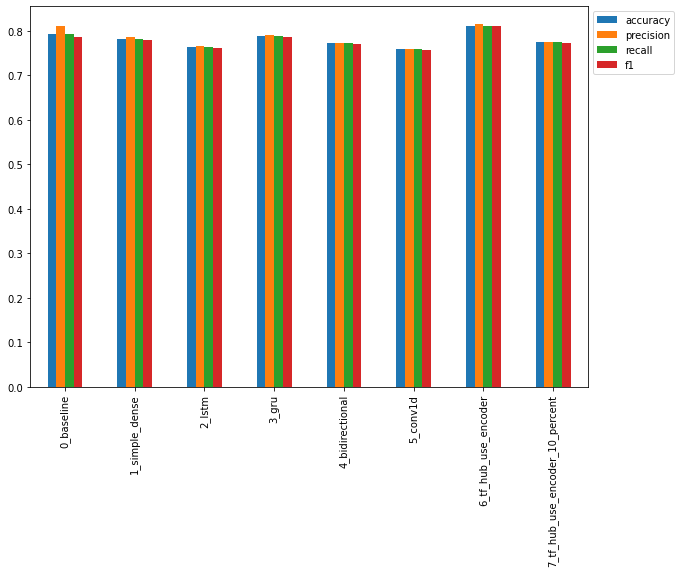

In [96]:
#plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

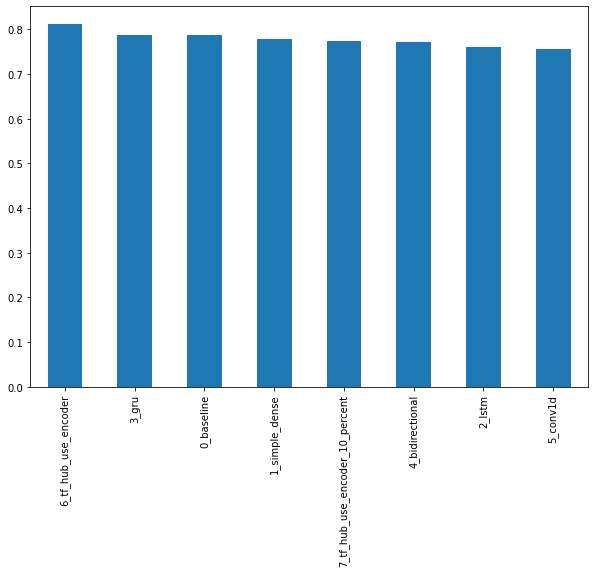

In [97]:
# plot model result by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Uploading our model traaining logs tonTensorboard.dev


In [98]:
# view TensorBoard logs transfer learning modelling experiments (plus all of our other models)
# Upload Tensorboard dev recored
!tensorboard dev upload --logdir ./nodel_lods/ \
  --name "nlp modelling" \
  --description "comparing the modelling" \
  --one_shot 


2023-03-06 16:47:51.135179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:47:51.135315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 16:47:51.135339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./nodel_lods/

This TensorBoard wi

## saving and loading a trained model 
there are two main formats to save a model to in Tensorflow:
1. the HDF5 format
2. The `SaveModel` format (this is the defultwhen using tensorflow)

In [99]:
# Save Tf hub sentence encoder model to HDF5 format
model_6.save("model_6.h5")

In [100]:
# load model with custom hub layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                              custom_objects={"KerasLayer": hub.KerasLayer})

In [101]:
# how does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4300 - accuracy: 0.8123


[0.4299755394458771, 0.8123359680175781]

In [102]:
# save TF Hub sentence encoder model to savemodel format
model_6.save("model_6_savemodel_format")

In [103]:
# load in a model from the Savemodel format
loaded_model_6_savedmodel_format = tf.keras.models.load_model("model_6_savemodel_format")

In [104]:
# evaluate model in savemodel format
loaded_model_6_savedmodel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4300 - accuracy: 0.8123


[0.4299755394458771, 0.8123359680175781]

## finding the most wrong example
* if our best model still isn't perfect, what examples is it getting wrong?
* and of these wrong examples which ones is it getting most wrong (those will prediction probabilities closet to the opposite class)

for example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [105]:
# Download a pretrained model from Google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-03-06 16:50:21--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   141MB/s    in 7.6s    

2023-03-06 16:50:29 (121 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [106]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.149447
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.736027
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987632
3,@camilacabello97 Internally and externally scr...,1,0.0,0.203810
4,Radiation emergency #preparedness starts with ...,1,1.0,0.735276


In [107]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.928631
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864153
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.856844
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.842598
628,@noah_anyname That's where the concentration c...,0,1.0,0.840277
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.815426
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.805534
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.791956
144,The Sound of Arson,0,1.0,0.770262
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.764646


In [107]:
# Check the false negatives ( model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


## making prediction on the test dataset


In [108]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 54ms/step
Pred: 1, Prob: 0.9312960505485535
Text:
#WAwildfire in #chelan? Wolverine fire results in evacuation. http://t.co/yePlnZPoWu

----

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.9124837517738342
Text:
More Natural Disaster Research Urgent http://t.co/5Cm0LfZhxn via #JakartaPost

----

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.08125633746385574
Text:
Watching Desolation of Smaug and I always love catching the cameos. Caught Jackson at the beginning and Colbert just now.

----

1/1 [==============================] - 0s 63ms/step
Pred: 0, Prob: 0.06494300067424774
Text:
Dj d wreck cut the beat

----

1/1 [==============================] - 0s 83ms/step
Pred: 0, Prob: 0.35947567224502563
Text:
3 out of the 4 people I'm camping with I would happily see fall of a cliff.

----

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.06804389506578445
Text:
I'll be at SFA very soon

## challenge .... predicting on tweets from the wild

In [109]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"


In [110]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [111]:


# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)



1/1 [==============================] - 0s 90ms/step
Pred: 0.0 (not real disaster) Prob: 0.04457463324069977
Text:
Life like an ensemble: take the best choices from others and make your own


In [112]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"


In [113]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 43ms/step
Pred: 1.0 (real disaster) Prob: 0.9621894359588623
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [114]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 82ms/step
Pred: 1.0 (real disaster) Prob: 0.9676557779312134
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff

In [115]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [116]:


# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred



24/24 [==============================] - 0s 18ms/step


(0.7158077940000567, 0.0009393803070866885)

In [117]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.036739580999892496, 4.821467322820538e-05)

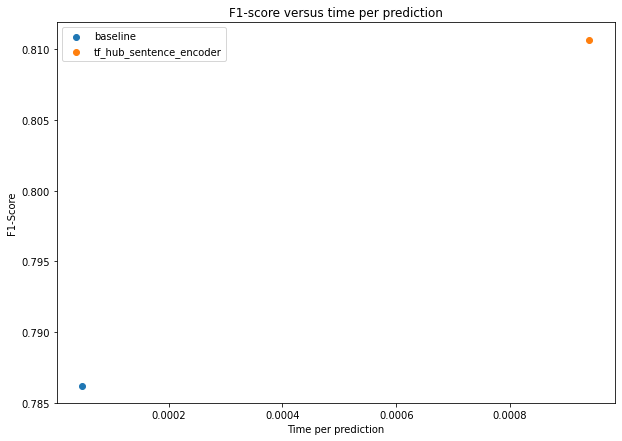

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");